<a href="https://www.kaggle.com/code/christiandeangelis1/hyperparameter-tuning-to-predict-test-scores?scriptVersionId=117044575" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/students-performance-in-exams/exams.csv


# Hello!

I am using a [dataset](https://www.kaggle.com/datasets/whenamancodes/students-performance-in-exams) of 1000 students to build a model that predicts test scores. We'll get some insight into what factors affect student performance. First I'll visualize at the data to see how scores vary between different features, then optimize a few models to make predictions.

I am using this as an exercise to practice hyperparameter optimization. I use Grid Search with 5-fold cross-validation to find the optimal hyperparameters for Random Forest and XGBoost. 

This dataset is relatively small and not ideal for this purpose, but this was good to do nonetheless.

# Setup

Quick look at the data. We have five features and three scores per sample. To make things simpler I create a 'score' column, which is the average of the math, reading, and writing scores. 

Aside from the scores, it is all categorical data. Thankfully it is clean and should be easy to encode. This dataset has no NaNs.  Gender, lunch, and test preparation are all binary. Parental level of education is the only ordered feature, so I'll use ordinal encoding. Finally race/ethnicity is unordered, so I'll use one-hot encoding for that.

In [2]:
data = pd.read_csv('/kaggle/input/students-performance-in-exams/exams.csv')

X_ob = [col for col in data if data[col].dtype == 'object']
X_ob = pd.DataFrame(data[X_ob])

y_values = data.drop(X_ob, axis=1)

n = X_ob['race/ethnicity']
n.name = 'new'
X_ob = pd.concat([X_ob, n], axis=1)

y = y_values.mean(axis=1)
y.name = 'score'

data['score'] = y

data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,score
0,male,group A,high school,standard,completed,67,67,63,65.666667
1,female,group D,some high school,free/reduced,none,40,59,55,51.333333
2,male,group E,some college,free/reduced,none,59,60,50,56.333333
3,male,group B,high school,standard,none,77,78,68,74.333333
4,male,group E,associate's degree,standard,completed,78,73,68,73.000000


# Data Exploration

Let's take at the data. We have a few groups where we'd expect score disparities.

Parental level of education, standard vs free lunch, and test preparation probably all affect scores about how you would expect

Let's take a look:

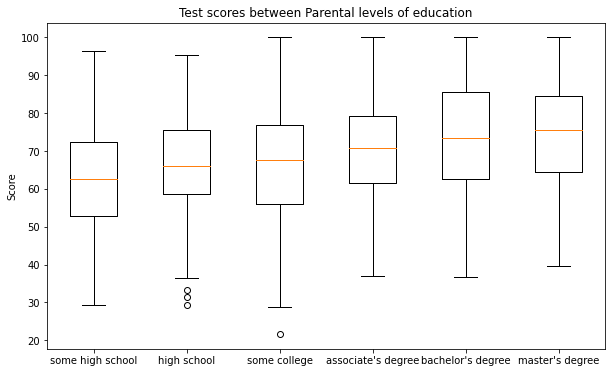

In [3]:
import matplotlib.pyplot as plt

SHS = data.loc[data['parental level of education'] == 'some high school']['score']
HS = data.loc[data['parental level of education'] == 'high school']['score']
SC = data.loc[data['parental level of education'] == 'some college']['score']
AD = data.loc[data['parental level of education'] == "associate's degree"]['score']
BD = data.loc[data['parental level of education'] == "bachelor's degree"]['score']
MD = data.loc[data['parental level of education'] == "master's degree"]['score']

educationData = [SHS, HS, SC, AD, BD, MD]

fig, ax = plt.subplots(figsize=(10,6))
ax.boxplot(educationData, vert=True)
ax.set_ylabel("Score")

ax.set_xticklabels(['some high school', 'high school','some college', 
              "associate's degree", "bachelor's degree", "master's degree"])
ax.set_title('Test scores between Parental levels of education')
fig.show()

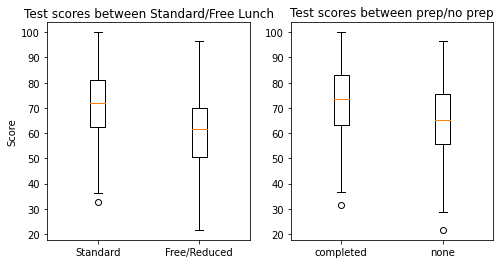

In [4]:
StandardLunch = data.loc[data['lunch'] == 'standard']['score']
FreeLunch = data.loc[data['lunch'] == 'free/reduced']['score']
Lunchdata = [StandardLunch, FreeLunch]

prep = data.loc[data['test preparation course'] == 'completed']['score']
noprep = data.loc[data['test preparation course'] == 'none']['score']
prepdata = [prep, noprep]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.boxplot(Lunchdata, vert=True)
ax1.set_xticklabels(['Standard', 'Free/Reduced'])
ax1.set_title('Test scores between Standard/Free Lunch')
ax1.set_ylabel("Score")

ax2.boxplot(prepdata, vert=True)
ax2.set_xticklabels(['completed', 'none'])

ax2.set_title('Test scores between prep/no prep')

fig.show()

We're given five race/ethnic groups, let's take a look at those

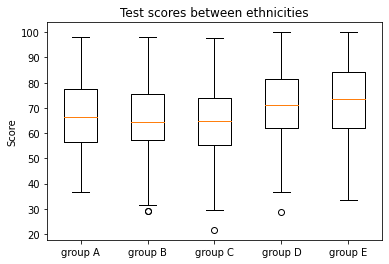

In [5]:
gA = data.loc[data['race/ethnicity'] == 'group A']['score']
gB = data.loc[data['race/ethnicity'] == 'group B']['score']
gC = data.loc[data['race/ethnicity'] == 'group C']['score']
gD = data.loc[data['race/ethnicity'] == 'group D']['score']
gE = data.loc[data['race/ethnicity'] == 'group E']['score']

dataM = [gA, gB, gC, gD, gE]

fig, ax = plt.subplots()
ax.boxplot(dataM, vert=True)
ax.set_xticklabels(['group A', 'group B', 'group C', 'group D', 'group E'])
ax.set_title('Test scores between ethnicities')
ax.set_ylabel("Score")
fig.show()

# Encoding

I'm creating a preprocessor to encode the data. As mentioned earlier, I'll use one-hot encoding for race/ethincity, ordinal encoding for parental level of education, and binary encoding for the remaining features. 

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

education_categories = [['some high school', 'high school','some college', 
              "associate's degree", "bachelor's degree", "master's degree"]]

oh_cols = ['race/ethnicity', 'new']
ord_cols = [col for col in X_ob if col not in oh_cols and col != 'parental level of education']


# Encode the columsn how we want, Ordinal for education, one-hot for race, and binary for the rest
edu_transformer = OrdinalEncoder(categories=education_categories)
ord_transformer = OrdinalEncoder()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('edu',edu_transformer, ['parental level of education']),
        ('ord',ord_transformer, ord_cols),
        ('oh',oh_transformer, oh_cols)
    ])

# Hyperparameter Tuning with GridSearchCV

Hyperparameters of an algorithm can be thought of as settings that affect the model's performance. *Parameters* are values that are learned during training, such as the slope and intercept in linear regression, or weights in a neural network. Hyperparameters, on the other hand, are set beforehand and are not changed during training. The process of optimizing hyperparameters is called hyperparameter tuning.

Two common methods of hyperparameter optimization are Grid Search and Random Search. Grid search exhaustively searches the hyperparameter space to find the optimal settings, which can be computationally expensive. Random search can be used when the hyperparameter space is large and will typically return good results. Here I will be using GridSearchCV, which incorporates cross-validation and exhaustively searches the hyperparameter combinations.

I am defining a funcition whose arguments are the model and the paramter grid to be searched. I do this to easily incorporate the preprocessing and model in a pipeline, which is passed into GridSearchCV. The mean abolsolute error is used as scoring with 5-fold cross-validation. 

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

def get_hyper(model, p_grid):

    # Combine established preprocessor and argument model into a pipeline
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('clf', model)
                     ])

    gs = GridSearchCV(estimator=clf, param_grid=p_grid, cv=5,scoring='neg_mean_absolute_error')
    gs.fit(X_ob, y)

    
    return gs

## XGBoost

Time to evaluate XGBoost, a gradient boosting model that is quite popular. You can read more about it [here](https://www.kaggle.com/code/alexisbcook/xgboost).

I am searching for the optimal n_estimators and learning_rate. 

Here MAE across the hyperparameter space:

Best MAE: -10.429787 using {'clf__learning_rate': 0.07, 'clf__n_estimators': 70}


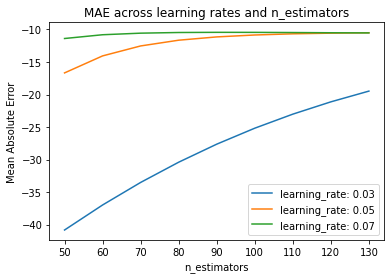

In [8]:
from xgboost import XGBRegressor

model = XGBRegressor(random_state=0)
p_grid = {'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130],
              'clf__learning_rate':[0.01, 0.03, 0.05, 0.07, 0.09, 0.11]}

gs = get_hyper(model, p_grid)

print("Best MAE: %f using %s" % (gs.best_score_, gs.best_params_))

means = gs.cv_results_['mean_test_score']
scores = np.array(means).reshape(len(p_grid['clf__learning_rate']), len(p_grid['clf__n_estimators']))

fig, ax = plt.subplots()
for i, value in enumerate(["0.03", "0.05", "0.07"]):
    ax.plot(p_grid["clf__n_estimators"], scores[i], label='learning_rate: ' + str(value))
ax.legend()
ax.set_xlabel('n_estimators')
ax.set_ylabel('Mean Absolute Error')
ax.set_title("MAE across learning rates and n_estimators")

fig.show()

## Random Forest

Now for Random Forest. There are several more hyperparameters I could test out, however it is quite computationally expensive, even if I used Random Search. Thus I am searching a relatively small section of the hyperparameter space.


note: I tested out a wider range of n_estimators and different max_depths, however training took way too long, so I left them out for the final  version. No combinations acheived a significantly better MAE. 

Best MAE: -10.729720 using {'clf__max_depth': 10, 'clf__n_estimators': 700}


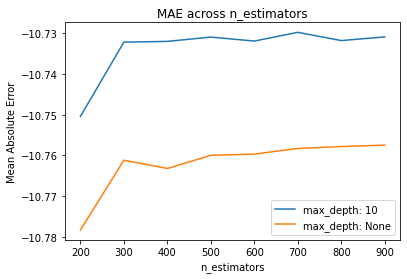

In [9]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(criterion="absolute_error",random_state=0)

p_grid = {"clf__n_estimators":[200,300,400,500,600,700,800,900],
         "clf__max_depth":[10,None]}

gs = get_hyper(model, p_grid)

print("Best MAE: %f using %s" % (gs.best_score_, gs.best_params_))

means = gs.cv_results_['mean_test_score']
scores = np.array(means).reshape(len(p_grid["clf__max_depth"]), len(p_grid["clf__n_estimators"]))

fig, ax = plt.subplots()
for i, value in enumerate(['10','None']):
    ax.plot(p_grid["clf__n_estimators"], scores[i], label="max_depth: " + str(value))
ax.legend()
ax.set_xlabel("n_estimators")
ax.set_ylabel("Mean Absolute Error")
ax.set_title("MAE across n_estimators")

fig.show()

## Bayesian Ridge

The hyperparamters for Bayesian ridge are the initial values of alpha and lambda. For this data, alpha and lambda always converge to the same values, regardless of the initial values, thus tuning is not necessary. For the sake of consistency, I test out several values of alpha_init, which all results in the same MAE.

In [10]:
from sklearn import linear_model

model = linear_model.BayesianRidge()

p_grid = {'clf__alpha_init':[1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.9],}

gs = get_hyper(model, p_grid)

print("Best MAE: %f using %s" % (gs.best_score_, gs.best_params_))

Best MAE: -9.985376 using {'clf__alpha_init': 1.9}


# Conclusion

All the the features influence exam scores in the direction you would expect. That is, factors that are a proxy for SES (parental education, standard/free lunch, test prep) all affect test performance. There are also disparities between racial groups, however they are not as significant. 

I successfully created a model that (decently) predicted performance. After tuning the hyperparameters of XGBoost and Random Forest, good 'ol linear regression beat both. Bayesian Ridge predicted student performance with an average MAE of 9.98, better than the other algorithms, however the difference is small.

This was mostly an exercise to practice tuning hyperparameters of different models, I am satisfied with the results. 